# Show4DSTEM Sparse Ingest + Adaptive Loop
Dedicated workflow notebook for real-data starts: ingest scanned points/blocks, propose adaptive next points, evaluate against reference, and export a reproducibility bundle.

In [1]:
try:
    %load_ext autoreload
    %autoreload 2
    %env ANYWIDGET_HMR=1
except Exception:
    pass

env: ANYWIDGET_HMR=1


In [ ]:
import json
import pathlib
import matplotlib.pyplot as plt
import numpy as np
import torch
import quantem.widget
from quantem.widget import Show4DSTEM
DEVICE = torch.device(
    'mps'
    if torch.backends.mps.is_available()
    else 'cuda'
    if torch.cuda.is_available()
    else 'cpu'
)
print(f'Using device: {DEVICE}')
def make_synthetic_4dstem(scan_shape=(32, 32), det_shape=(64, 64), seed=13, device=None):
    if device is None:
        device = DEVICE
    torch.manual_seed(seed)
    sy, sx = scan_shape
    ky, kx = det_shape
    y = torch.linspace(-1.0, 1.0, sy, device=device)
    x = torch.linspace(-1.0, 1.0, sx, device=device)
    Y, X = torch.meshgrid(y, x, indexing='ij')
    strain = 0.30 * torch.sin(2.0 * np.pi * (6.0 * X + 0.4 * Y))
    strain += 0.24 * torch.sin(2.0 * np.pi * (5.8 * Y - 0.3 * X))
    defect = 0.60 * torch.exp(-((X + 0.22) ** 2 + (Y - 0.12) ** 2) / 0.05)
    defect += 0.42 * torch.exp(-((X - 0.28) ** 2 + (Y + 0.24) ** 2) / 0.04)
    field = strain + defect
    ky_axis = torch.linspace(0.0, float(ky - 1), ky, device=device)
    kx_axis = torch.linspace(0.0, float(kx - 1), kx, device=device)
    KY, KX = torch.meshgrid(ky_axis, kx_axis, indexing='ij')
    KY = KY[None, None, :, :]
    KX = KX[None, None, :, :]
    cy = (ky - 1) / 2.0
    cx = (kx - 1) / 2.0
    shift_y = 1.3 * field[:, :, None, None]
    shift_x = -1.1 * field[:, :, None, None]
    dp = torch.zeros((sy, sx, ky, kx), device=device)
    dp += 180.0 * torch.exp(-((KY - cy) ** 2 + (KX - cx) ** 2) / (2.0 * 2.6**2))
    spots = [(-14.0, 0.0, 70.0), (14.0, 0.0, 70.0), (0.0, -14.0, 66.0), (0.0, 14.0, 66.0), (-10.0, -10.0, 52.0), (10.0, 10.0, 52.0)]
    amp = 1.0 + 0.45 * torch.relu(field[:, :, None, None])
    for dy, dx, a in spots:
        dp += (a * amp) * torch.exp(-((KY - (cy + dy + shift_y)) ** 2 + (KX - (cx + dx + shift_x)) ** 2) / (2.0 * 2.0**2))
    if device.type == 'mps':
        shot = torch.poisson(torch.clamp(dp.cpu(), min=0.0)).to(device)
    else:
        shot = torch.poisson(torch.clamp(dp, min=0.0))
    dp = torch.clamp(shot + 0.5 * torch.randn_like(shot), min=0.0)
    return dp.cpu().numpy().astype(np.float32)
print(f"quantem.widget {quantem.widget.__version__}")

In [3]:
# Set DATA_PATH to your real full-raster cube (.npy or .npz).
# Expected shape: (scan_r, scan_c, det_r, det_c)
# Optional 5D: (frames, scan_r, scan_c, det_r, det_c) -> first frame is used here.
DATA_PATH = None  # e.g. '/path/to/real_4dstem.npy'
NPZ_KEY = None
if DATA_PATH and pathlib.Path(DATA_PATH).exists():
    path = pathlib.Path(DATA_PATH)
    if path.suffix.lower() == '.npy':
        full_data = np.load(path, allow_pickle=False)
    elif path.suffix.lower() == '.npz':
        with np.load(path, allow_pickle=False) as z:
            key = NPZ_KEY if NPZ_KEY is not None else list(z.keys())[0]
            full_data = z[key]
    else:
        raise ValueError(f'Unsupported suffix: {path.suffix}')
else:
    full_data = make_synthetic_4dstem(scan_shape=(32, 32), det_shape=(64, 64), seed=13, device=DEVICE)
full_data = np.asarray(full_data, dtype=np.float32)
if full_data.ndim == 5:
    full_data = full_data[0]  # demo uses one frame
if full_data.ndim != 4:
    raise ValueError(f'Expected 4D data after optional frame select, got {full_data.shape}')
print('full_data shape:', full_data.shape)

full_data shape: (32, 32, 64, 64)


In [4]:
# Planner uses full data (ground truth); live widget starts empty.
planner = Show4DSTEM(full_data, pixel_size=0.78, k_pixel_size=0.52)
planner.auto_detect_center()
planner.roi_circle()
planner.roi_radius = max(6.0, planner.bf_radius * 0.9)
live = Show4DSTEM(np.zeros_like(full_data), pixel_size=planner.pixel_size, k_pixel_size=planner.k_pixel_size)
live.center_row = planner.center_row
live.center_col = planner.center_col
live.bf_radius = planner.bf_radius
live.roi_mode = planner.roi_mode
live.roi_radius = planner.roi_radius
live.roi_center_row = planner.roi_center_row
live.roi_center_col = planner.roi_center_col
reference_vi = planner._virtual_image_from_frame_array(full_data)
n_total = full_data.shape[0] * full_data.shape[1]
print('reference virtual image shape:', reference_vi.shape)
live

reference virtual image shape: (32, 32)


Show4DSTEM(shape=(32, 32, 64, 64), sampling=(0.78 Å, 0.52 mrad), pos=(16, 16))

In [5]:
# Example 1: adaptive loop with ingest_scan_block + evaluate_against_reference
fractions = [0.10, 0.20, 0.30]
history = []
for frac in fractions:
    target_points = int(round(frac * n_total))
    while live.get_sparse_state()['n_sampled'] < target_points:
        remaining = target_points - live.get_sparse_state()['n_sampled']
        batch_k = min(24, remaining)
        proposed = planner.propose_next_points(
            batch_k,
            strategy='adaptive',
            budget={'max_total_points': target_points, 'min_spacing': 2, 'dose_lambda': 0.25},
        )
        if not proposed:
            break
        rows = [p[0] for p in proposed]
        cols = [p[1] for p in proposed]
        block = np.stack([full_data[r, c] for r, c in proposed], axis=0)
        # Keep planner/live sparse masks synchronized.
        planner.ingest_scan_block(rows, cols, block)
        live.ingest_scan_block(rows, cols, block)
    report = live.evaluate_against_reference(reference=reference_vi)
    history.append({
        'target_fraction': frac,
        'used_fraction': report['sampled_fraction'],
        'n_sampled': report['n_sampled'],
        'rmse': report['metrics']['rmse'],
        'nrmse': report['metrics']['nrmse'],
        'psnr': report['metrics']['psnr'],
    })
history

[{'target_fraction': 0.1,
  'used_fraction': 0.099609375,
  'n_sampled': 102,
  'rmse': 88.87198647756642,
  'nrmse': 0.15721756179445903,
  'psnr': 38.96347893730654},
 {'target_fraction': 0.2,
  'used_fraction': 0.2001953125,
  'n_sampled': 205,
  'rmse': 82.24415229022365,
  'nrmse': 0.14549269806391757,
  'psnr': 39.63667611917272},
 {'target_fraction': 0.3,
  'used_fraction': 0.2998046875,
  'n_sampled': 307,
  'rmse': 73.97913293203023,
  'nrmse': 0.13087159817427824,
  'psnr': 40.55659195317672}]

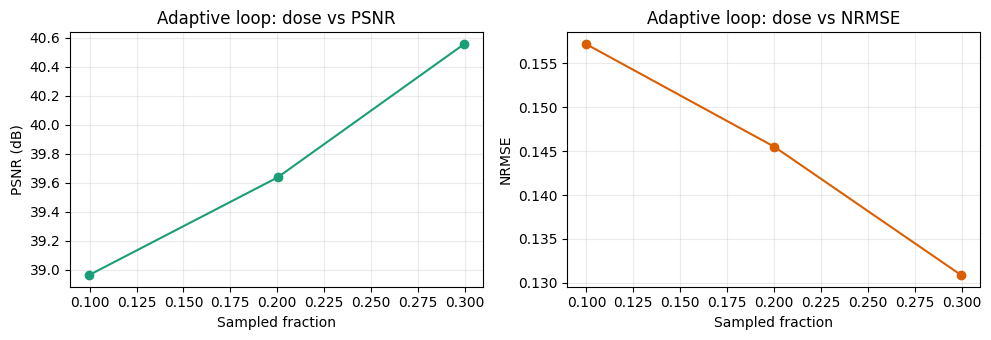

In [6]:
# Plot dose-quality trajectory
x = [h['used_fraction'] for h in history]
psnr = [h['psnr'] for h in history]
nrmse = [h['nrmse'] for h in history]
fig, ax = plt.subplots(1, 2, figsize=(10, 3.5))
ax[0].plot(x, psnr, marker='o', color='#1b9e77')
ax[0].set_xlabel('Sampled fraction')
ax[0].set_ylabel('PSNR (dB)')
ax[0].set_title('Adaptive loop: dose vs PSNR')
ax[0].grid(alpha=0.25)
ax[1].plot(x, nrmse, marker='o', color='#d95f02')
ax[1].set_xlabel('Sampled fraction')
ax[1].set_ylabel('NRMSE')
ax[1].set_title('Adaptive loop: dose vs NRMSE')
ax[1].grid(alpha=0.25)
plt.tight_layout()


In [7]:
# Example 2: one-shot block ingest from a coarse raster
block_widget = Show4DSTEM(np.zeros_like(full_data), pixel_size=planner.pixel_size, k_pixel_size=planner.k_pixel_size)
block_widget.center_row = planner.center_row
block_widget.center_col = planner.center_col
block_widget.bf_radius = planner.bf_radius
block_widget.roi_mode = planner.roi_mode
block_widget.roi_radius = planner.roi_radius
block_widget.roi_center_row = planner.roi_center_row
block_widget.roi_center_col = planner.roi_center_col
rows = []
cols = []
for r in range(0, full_data.shape[0], 4):
    for c in range(0, full_data.shape[1], 4):
        rows.append(r)
        cols.append(c)
dp_block = np.stack([full_data[r, c] for r, c in zip(rows, cols)], axis=0)
block_widget.ingest_scan_block(rows, cols, dp_block)
block_report = block_widget.evaluate_against_reference(reference=reference_vi)
block_report

{'reference_kind': 'virtual_image',
 'frame_idx': 0,
 'n_sampled': 64,
 'sampled_fraction': 0.0625,
 'metrics': {'rmse': 91.91219485193464,
  'nrmse': 0.1625957936412955,
  'mae': 71.32638549804688,
  'psnr': 38.67131394838465},
 'scan_shape': {'rows': 32, 'cols': 32},
 'detector_shape': {'rows': 64, 'cols': 64}}

In [8]:
# Example 3: sparse checkpoint -> restore
sparse_state = live.get_sparse_state()
restored = Show4DSTEM(np.zeros_like(full_data), pixel_size=planner.pixel_size, k_pixel_size=planner.k_pixel_size)
restored.center_row = planner.center_row
restored.center_col = planner.center_col
restored.bf_radius = planner.bf_radius
restored.roi_mode = planner.roi_mode
restored.roi_radius = planner.roi_radius
restored.roi_center_row = planner.roi_center_row
restored.roi_center_col = planner.roi_center_col
restored.set_sparse_state(sparse_state['mask'], sparse_state['sampled_data'])
restored_report = restored.evaluate_against_reference(reference=reference_vi)
print('restored n_sampled:', sparse_state['n_sampled'])
print('restored metrics:', restored_report['metrics'])

restored n_sampled: 307
restored metrics: {'rmse': 73.97913293203023, 'nrmse': 0.13087159817427824, 'mae': 49.56550598144531, 'psnr': 40.55659195317672}


In [9]:
# Example 4: reproducibility bundle export
OUT = pathlib.Path('notebooks/show4dstem/paper_sparse_ingest')
OUT.mkdir(parents=True, exist_ok=True)
manifest_path = live.export_session_bundle(OUT / 'session_bundle')
manifest = json.loads(manifest_path.read_text())
manifest['files']

{'state': 'notebooks/show4dstem/paper_sparse_ingest/session_bundle/widget_state.json',
 'sparse_npz': 'notebooks/show4dstem/paper_sparse_ingest/session_bundle/sparse_state.npz',
 'sparse_points_json': 'notebooks/show4dstem/paper_sparse_ingest/session_bundle/sparse_points.json',
 'image': 'notebooks/show4dstem/paper_sparse_ingest/session_bundle/current_all.png',
 'image_metadata': 'notebooks/show4dstem/paper_sparse_ingest/session_bundle/current_all.json',
 'reproducibility_report': 'notebooks/show4dstem/paper_sparse_ingest/session_bundle/reproducibility_report.json'}

In [10]:
live

Show4DSTEM(shape=(32, 32, 64, 64), sampling=(0.78 Å, 0.52 mrad), pos=(16, 16))